In [1]:
import os
import random

import pandas as pd
import numpy as np
import scipy as sp

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score

import tqdm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict

from joblib import Parallel, delayed

import scipy as sp

import gc

from adamw import AdamW
from clr import CyclicLR

import pickle

import cv2

from augmentations import *
from trainer import *
from utils import *
from datasets import *
from models import *
from losses import *

In [2]:
seed_everything()

In [10]:
# pretrainedmodels.model_names

In [11]:
def get_f2_score(model, loader, test_df, use_sigmoid=False, t=0.2, binarize_func=None):
    logits = predict(model, loader)
    if use_sigmoid:
        logits = sigmoid(logits)
    lbls_oh = create_oh_labels(test_df, len(labels_df))

    return fbeta_score(lbls_oh, logits >= t, 2, average='micro')

In [13]:
class DynamicWeightsSampler(torch.utils.data.sampler.WeightedRandomSampler):
    def __init__(self, undersample=0.9, oversample=1.25, **kwargs):
        super().__init__(**kwargs)
        self.mean_weights = self.weights.mean().item()
        self.over_sample = oversample
        self.under_sample = undersample
        
    def step(self):
        self.weights[self.weights <= self.mean_weights] *= self.over_sample
        self.weights[self.weights > self.mean_weights] *= self.under_sample

In [14]:
def f2_threshold_wise(y_true, probs, tvals=np.linspace(0.1, 0.9, 100), disable_tqdm=False, zero_labels=[]):
    def _process_single(t):
        preds = binarize_prediction(probs, t)
        return fbeta_score(y_true, preds, 2, average='samples')
    
    return Parallel(n_jobs=16)(delayed(_process_single)(t) for t in tqdm_notebook(tvals, disable=disable_tqdm, leave=False))

In [16]:
def fbeta_min(t, y_true, logits):
    return -1*fbeta_score(y_true, logits >= t, 2, average='micro')

def reduce_loss(loss):
    return loss.sum() / loss.shape[0]

In [21]:
labels_df = pd.read_csv('../input/labels.csv')
df = pd.read_csv('../input/train.csv')
df['attribute_ids'] = df['attribute_ids'].apply(lambda x: [int(idx) for idx in x.split()])
df['image'] = df['id'].apply(lambda idx: idx + '.png')

In [22]:
df_labels_oh = create_oh_labels(df, len(labels_df)).astype(int)
labels_freq = df_labels_oh.sum(axis=0)

In [23]:
sum(labels_freq > 3)/len(labels_freq)

0.9592021758839528

In [24]:
all_lbls_oh = create_oh_labels(df, len(labels_df))
class_freq = all_lbls_oh.sum(axis=0)/all_lbls_oh.shape[0]

In [26]:
# _ = plt.hist(base_weights, bins=25)

In [27]:
folds = make_folds(df, 5)

100%|██████████| 109237/109237 [00:01<00:00, 72255.84it/s]


In [28]:
train_df, val_df = df[folds != 0].copy(), df[folds == 0].copy()

In [ ]:
val_lbls_oh = create_oh_labels(val_df, len(labels_df))
train_lbls_oh = create_oh_labels(train_df, len(labels_df))

In [ ]:
f2_history_baseline = pickle.load(open('seresnext_256x256_f2.bin', 'rb'))
val_history_baseline = pickle.load(open('seresnext_256x256_val.bin', 'rb'))
train_history_baseline = pickle.load(open('seresnext_256x256_train.bin', 'rb'))

In [ ]:
class ResizeAspect(object):
    def __init__(self, size):
        self.size = size
        
    def __call__(self, img):
        img_shape = np.array(img.size)
        coeff = np.min(img_shape/self.size)
        
        if coeff < 1:
            target_shape = img_shape/coeff

            return img.resize(target_shape.astype(int))
        else:
            return img

In [ ]:
#brightness/contrast/gamma

img_size = (300, 300)

means = np.array([0.485, 0.456, 0.406])
stds = np.array([0.229, 0.224, 0.225])

train_trans = transforms.Compose([
                     transforms.RandomCrop(img_size),
                     transforms.RandomHorizontalFlip(p=0.5),
                     RandomBrightness(p=0.5),
                     RandomGamma(p=0.5),
                     RandomHueSaturation(p=0.5),
                ])

val_trans = transforms.Compose([
                     transforms.RandomCrop(img_size),                     
                ])

tensor_trans = transforms.Compose(
                                [
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=means, std=stds), 
                                ])
    

In [ ]:
batch_size = 32
accum_steps = 2
kwargs = {'num_workers': 8, 'pin_memory': True}

sigmoid_out = True

f2_history_mixup = list()
train_history_mixup = list()
val_history_mixup = list()

train_dataset = BaselineDataset(train_df, '../input/train', len(labels_df), trans=train_trans, tensor_trans=tensor_trans)
# train_dataset = BaselineZeroedDataset(train_df, '../input/train', len(labels_df), zero_classes=zero_classes,
#                                       trans=train_trans, tensor_trans=tensor_trans)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)

val_dataset = BaselineDataset(val_df, '../input/train', len(labels_df), trans=val_trans, tensor_trans=tensor_trans)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs)


model = NeuralNetComplexHead(SeResnext50Body(), len(labels_df),  sigmoid=sigmoid_out, use_drop=True, input_size=2048)
model.cuda()

loss_fn = FocalLoss(2)

# loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction='mean')
# loss_fn = nn.BCEWithLogitsLoss(reduction='none')
# loss_fn = CustomF1Loss()

lr = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = AdamW(model.parameters(), lr=lr, weight_decay=5e-4)
scheduler_epoch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=4, threshold=0.01, verbose=True)
# scheduler_epoch = None
scheduler = None

head_epochs = 1
body_epochs = 15

N_CLASSES = 1103
for epoch in tqdm.tnrange(head_epochs):
    train_loss, val_loss, f2_loss = train_cycle(model, loss_fn, optimizer, None, train_loader, val_loader, 
                                                val_lbls_oh, 32, loss_reduction=None, iterate_threshold=True)

    f2_history_mixup.append(f2_loss)
    train_history_mixup.append(train_loss)
    val_history_mixup.append(val_loss)
    
#     if scheduler_epoch:
#         scheduler_epoch.step(val_loss)

model.freeze_body(False)

for epoch in tqdm.tnrange(15):
    train_loss, val_loss, f2_loss = train_cycle(model, loss_fn, optimizer, scheduler, train_loader, val_loader, 
                                                val_lbls_oh, 32, loss_reduction=None, iterate_threshold=True)

    f2_history_mixup.append(f2_loss)
    train_history_mixup.append(train_loss)
    val_history_mixup.append(val_loss)
    
    if scheduler_epoch:
        scheduler_epoch.step(val_loss)    

Train: 6.118, val: 3.984, f2: 0.398, best threshold: 0.255



Train: 3.272, val: 2.837, f2: 0.522, best threshold: 0.288


Train: 2.781, val: 2.688, f2: 0.550, best threshold: 0.288


Train: 2.514, val: 2.606, f2: 0.566, best threshold: 0.280


Train: 2.322, val: 2.543, f2: 0.576, best threshold: 0.288


Train: 2.163, val: 2.559, f2: 0.580, best threshold: 0.288


Train: 2.025, val: 2.556, f2: 0.586, best threshold: 0.288


In [40]:
torch.save(model.state_dict(), 'seresnext50_fold_0_epoch_15_bce_bs16.pth')

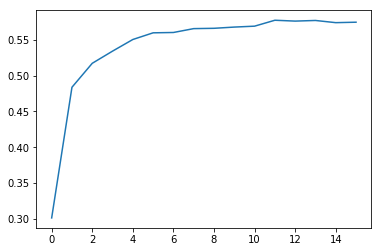

In [39]:
plt.plot(f2_history_mixup)

In [ ]:
plt.figure(figsize=(15,10))

plt.plot(f2_history_baseline, label='Baseline')
plt.plot(f2_history_mixup, label='Baseline + Mixup')
plt.plot(f2_history_mixup_focal, label='Baseline + Mixup')

plt.legend()

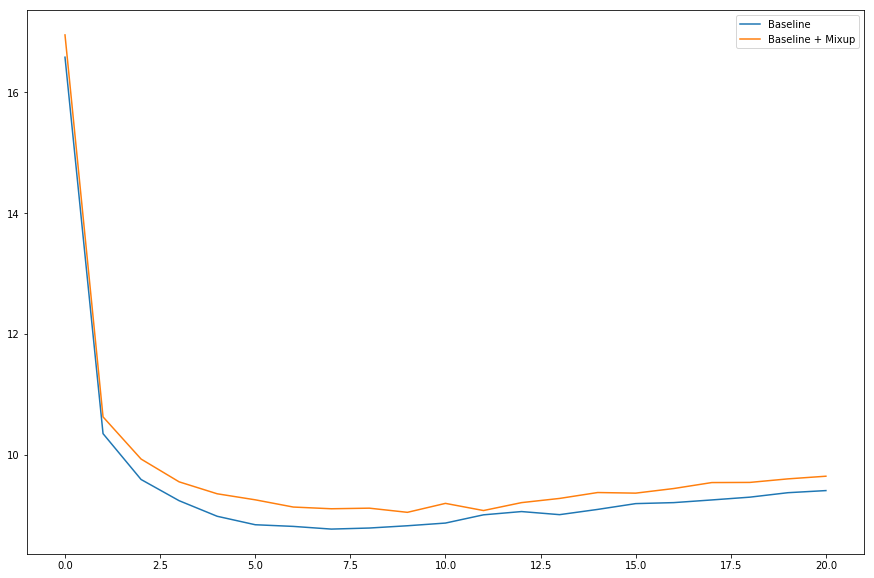

In [38]:
plt.figure(figsize=(15,10))

plt.plot(val_history_baseline, label='Baseline')
plt.plot(val_history_mixup, label='Baseline + Mixup')

plt.legend()

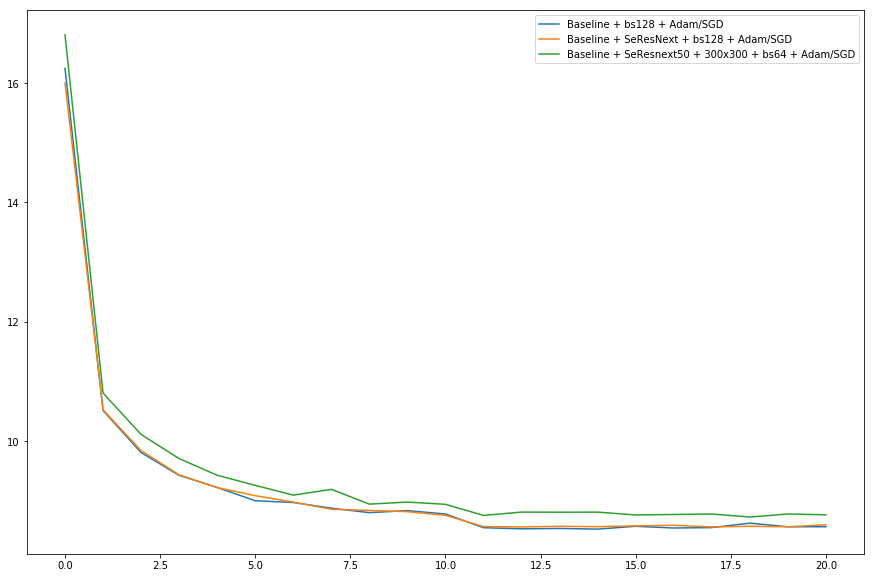

In [91]:
plt.figure(figsize=(15,10))

# plt.plot(val_history_baseline, label='Baseline')
# plt.plot(val_history_2, label='Baseline + ADAM/SGD')
plt.plot(val_history_3, label='Baseline + bs128 + Adam/SGD')
# plt.plot(val_history_4, label='Baseline + SeResnet50 + bs128 + Adam/SGD')
plt.plot(val_history_5, label='Baseline + SeResNext + bs128 + Adam/SGD')
plt.plot(val_history_6, label='Baseline + SeResnext50 + 300x300 + bs64 + Adam/SGD')
plt.legend()